In [14]:
import statistics
import numpy as np
import torch
import sklearn.metrics as skm
import torch

import fastai
import tsai
import copy
import shap
import math

import pandas as pd


# Assuming your data is in a variable 'X_trainvalid' (3D numpy array)

import torch.nn as nn
import importlib
import dice_ml
#importlib.reload(dice_ml.explainer_interfaces.dice_pytorch)
importlib.reload(dice_ml.explainer_interfaces.explainer_base)
from dice_ml.utils.exception import UserConfigValidationException
from dice_ml.explainer_interfaces.dice_pytorch import DicePyTorch
from dice_ml.utils import helpers # helper functions
from sklearn.model_selection import train_test_split
importlib.reload(fastai)
importlib.reload(tsai)


from tsai.all import *
from tsai.data.validation import get_splits
from tsai.models.InceptionTimePlus import InceptionTimePlus
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback, ReduceLROnPlateau
from fastai.data.transforms import Categorize
from fastai.losses import FocalLossFlat
from fastai.metrics import accuracy, BrierScore, F1Score, RocAucBinary, APScoreBinary

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


import Data_load_neat as Data_load
import MLmodel_opt_learner_neat as MLmodel_opt_learner

In [15]:
np.set_printoptions(precision=4,suppress = True)

In [16]:
# load in arguments from command line
name = "data_2real1bigdet"
model_name="ResNet"
randnum_split=3
epochs=1
device = 1
filepath="/home/DIDE/smishra/Simulations/"
folds=5

In [17]:

X_raw = np.load("".join([filepath,"input_data/",name, "_X.npy"])).astype(np.float32)


Y_raw = np.squeeze(np.load("".join([filepath,"input_data/",name, "_YH.npy"])))
Y = Y_raw[:, np.shape(Y_raw)[1] - 1]

print(X_raw.shape)


(100000, 9, 40)


In [18]:
## Function to obtain the train/test split
X_trainvalid, Y_trainvalid, X_test, Y_test, splits = Data_load.split_data(X=X_raw,Y=Y,randnum=randnum_split)


Counter({0.0: 93975, 1.0: 6025}) Counter({0.0: 75180, 1.0: 4820}) Counter({0.0: 18795, 1.0: 1205})


In [19]:
# Give the architecture for each model
if model_name=="LSTMFCN":
    arch=LSTM_FCNPlus

if model_name=="TCN":
    arch=TCN

if model_name=="XCM":
    arch=XCMPlus

if model_name=="ResCNN":
    arch=ResCNN

if model_name=="ResNet":
    arch=ResNetPlus

if model_name=="InceptionTime":
    arch=InceptionTimePlus

if model_name=="MLSTMFCN":
    arch=MLSTM_FCNPlus


## Set seed
Data_load.random_seed(randnum_split)

## split out the test set
splits_9010 = get_splits(
        Y_trainvalid,
        valid_size=0.1,
        stratify=True,
        shuffle=True,
        test_size=0,
        show_plot=False,
        random_state=randnum_split
        )
Xtrainvalid90=X_trainvalid[splits_9010[0]]
Ytrainvalid90=Y_trainvalid[splits_9010[0]]
Xtrainvalid10=X_trainvalid[splits_9010[1]]
Ytrainvalid10=Y_trainvalid[splits_9010[1]]

randnum=1

Random state set:3, cuda used: True


In [20]:
def test_results(f_model,X_test,Y_test):

    valid_dl=f_model.dls.valid

    # obtain probability scores, predicted values and targets
    test_ds=valid_dl.dataset.add_test(X_test,Y_test)
    test_dl=valid_dl.new(test_ds)
    test_probas, test_targets,test_preds=f_model.get_preds(dl=test_dl,with_decoded=True,save_preds=None,save_targs=None)

    # get the min, max and median of probability scores for each class
    where1s=np.where(Y_test==1)
    where0s=np.where(Y_test==0)
    test_probasout=test_probas.numpy()
    test_probasout=test_probasout[:,1]
    print("Y equal 0:")
    print([min(test_probasout[where0s]),statistics.mean(test_probasout[where0s]),max(test_probasout[where0s])])
    print("Y equal 1:")
    print([min(test_probasout[where1s]),statistics.mean(test_probasout[where1s]),max(test_probasout[where1s])])

    ## get the various metrics for model fit
    acc=skm.accuracy_score(test_targets,test_preds)
    prec=skm.precision_score(test_targets,test_preds)
    rec=skm.recall_score(test_targets,test_preds)
    fone=skm.f1_score(test_targets,test_preds)
    auc=skm.roc_auc_score(test_targets,test_preds)
    prc=skm.average_precision_score(test_targets,test_preds)
    print(f"accuracy: {acc:.4f}")
    print(f"precision: {prec:.4f}")
    print(f"recall: {rec:.4f}")
    print(f"f1: {fone:.4f}")
    print(f"auc: {auc:.4f}")
    print(f"prc: {prc:.4f}")

    return acc, prec, rec, fone, auc, prc

In [21]:

# loop for fitting model with generic/pre-specified hyperparameters
lr_max=1e-3
batch_size=32
alpha=0.5
gamma=2

colnames=["data","model","seed","epochs", "accuracy", "precision", "recall", "f1", "auc","prc", "time","lr_max","batch_size","alpha","gamma"]
output = pd.DataFrame(columns=colnames)

# Fitting the model on train/test with pre-selected hyperparameters
# define the metrics for model fitting output
metrics=[accuracy,F1Score(),RocAucBinary(),BrierScore(),APScoreBinary()]
weights=torch.tensor([alpha,1-alpha], dtype=torch.float).to(device)

ESPatience=2

# prep the data for the model
tfms=[None,[Categorize()]]
dsets = TSDatasets(X_trainvalid, Y_trainvalid, tfms=tfms, splits=splits_9010,inplace=True)

dls=TSDataLoaders.from_dsets(
    dsets.train,
    dsets.valid,
    bs=batch_size,
    num_workers=0,
    device=device
    )

for i in range(10):
    x,y = dls.one_batch()
    print(sum(y)/len(y))

print(dls.c)
print(dls.len)
print(dls.vars)


TensorCategory(0.0625, device='cuda:1')
TensorCategory(0.0625, device='cuda:1')
TensorCategory(0.0625, device='cuda:1')
TensorCategory(0.0625, device='cuda:1')
TensorCategory(0., device='cuda:1')
TensorCategory(0.0938, device='cuda:1')
TensorCategory(0.1250, device='cuda:1')
TensorCategory(0.0938, device='cuda:1')
TensorCategory(0., device='cuda:1')
TensorCategory(0.0312, device='cuda:1')
2
40
9


Random state set:1, cuda used: True


epoch,train_loss,valid_loss,accuracy,f1_score,roc_auc_score,brier_score_loss,average_precision_score,time
0,0.000002,0.000001,1.000000,1.000000,1.000000,0.000000,1.000000,01:14


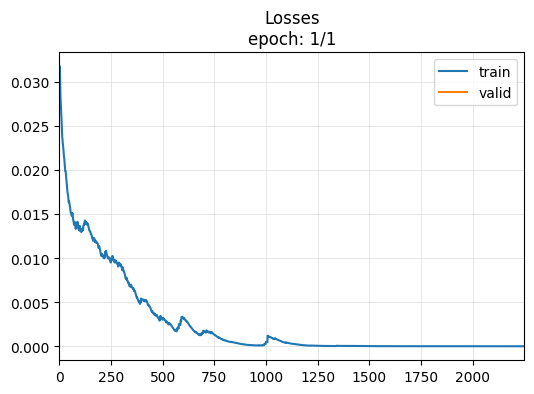

not enough values to plot a chart


In [22]:
Data_load.random_seed2(randnum,dls=dls)

model = arch(dls.vars, dls.c,dls.len)

model.to(device)

learn = Learner(
    dls, 
    model, 
    metrics=metrics,
    loss_func=FocalLossFlat(gamma=torch.tensor(gamma).to(device),weight=weights),
    cbs=[EarlyStoppingCallback(patience=ESPatience),ReduceLROnPlateau(),ShowGraph()]
    )

learn.fit_one_cycle(epochs, lr_max)

#MLmodel_opt_learner.test_results(learn,X_test,Y_test)


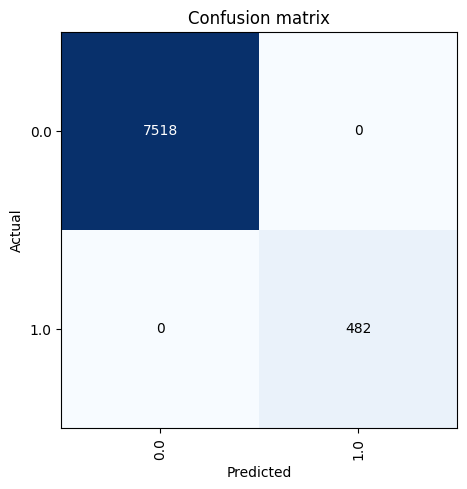

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [10]:
# Import the necessary libraries
import numpy as np
import torch
from tsai.all import *  # Import tsai and other related libraries
from dice_ml.model_interfaces.pytorch_model import PyTorchModel
from dice_ml import Dice

# Define a custom model class that adheres to the DICE framework
class CustomTSaiModel(PyTorchModel):
    def __init__(self, model):
        super(CustomTSaiModel, self).__init__(model)

    def predict_fn(self, query_instance):
        # Your tsai-based model's prediction logic
        # Ensure that you can convert the query_instance into a format that your model expects
        # Replace this with your actual prediction logic
        # Example: return self.model.predict(query_instance)
        return torch.tensor([0.7])  # Replace with your prediction

# Define a sample query instance (3D time series data) for which you want a counterfactual
query_instance = torch.tensor(np.random.rand(10, 5, 7))  # Replace with your actual 3D time series data

# Load your pre-fitted tsai-based model
# Replace this with your code to load the pre-fitted model
your_tsai_model = learn.model.cpu()  # Load your pre-fitted model

# Initialize the custom model
custom_model = CustomTSaiModel(model=your_tsai_model)  # Replace with your tsai-based model
data_interface = PyTorchDataInterface()
dice = Dice(data_interface, model_interface=custom_model)


# Generate a counterfactual explanation
counterfactual = dice.generate_counterfactuals(query_instance, total_CFs=5, desired_class="opposite")

# Print the counterfactuals
print("Counterfactual Explanations:")
for cf in counterfactual.cf_examples:
    print(cf.final_cfs[0])

# Analyze and visualize the generated counterfactual explanations
# Replace this with your own analysis and visualization code





NameError: name 'learn' is not defined

In [ ]:
import numpy as np
import pandas as pd
import torch
import dice_ml

# Assuming your data is in a variable 'X_trainvalid' (3D numpy array)

# Define the original dimensions
individuals, features, time_points = X_trainvalid.shape

# Create a custom model that takes the 3D input data
class CustomModel(torch.nn.Module):
    def __init__(self, original_model):
        super(CustomModel, self).__init__()
        self.original_model = original_model

    def forward(self, input_3d):
        # Apply the original model's forward pass
        output = self.original_model(input_3d)
        return output

# Instantiate the custom model using your existing model
learn_model = learn.model.cpu()  # Assuming this is your trained model
custom_model = CustomModel(learn_model)

# Reshape the 3D input data
input_3d = torch.tensor(X_trainvalid, dtype=torch.float32)




# Create a pandas DataFrame from the 3D input data
reshaped_data = input_3d.reshape((individuals, -1))
column_names = [f"feature_{i}_time_{j}" for i in range(features) for j in range(time_points)]
df = pd.DataFrame(reshaped_data.numpy(), columns=column_names)


# Set the outcome variable (replace 'Y_trainvalid' with your actual outcome data)
outcome_variable = Y_trainvalid
df['resp_out'] = outcome_variable

# Continue with DICE-ML for explanations and fairness assessments

# Create a Dice-ML Data object using the transformed 3D data
d = dice_ml.Data(dataframe=df,  continuous_features=[],categorical_features=df.columns.tolist()[:-1], outcome_name="resp_out")

# Using sklearn backend
m = dice_ml.Model(model=custom_model, backend="PYT")

# Using method=gradient for generating counterfactuals
exp = dice_ml.Dice(d, m, method="gradient")

# Now you can use 'exp' to explain model predictions and assess fairness
# For example, you can generate counterfactuals as follows:
query_instance = input_3d[0]  # Assuming you want to explain the first instance
explanation = exp.generate_counterfactuals(query_instance)



RuntimeError: Given groups=1, weight of size [64, 9, 7], expected input[1, 1, 360] to have 9 channels, but got 1 channels instead

In [ ]:


# Define the original dimensions
individuals, features, time_points = X_trainvalid.shape



# Instantiate the custom model using your existing model
learn_model = learn.model.cpu()  # Assuming this is your trained model


# Reshape the 3D input data
input_3d = torch.tensor(X_trainvalid, dtype=torch.float32)


# Create a pandas DataFrame from the 3D input data
reshaped_data = input_3d.reshape((individuals, -1))
column_names = [f"feature_{i}_time_{j}" for i in range(features) for j in range(time_points)]
df = pd.DataFrame(reshaped_data.numpy(), columns=column_names)


# Set the outcome variable (replace 'Y_trainvalid' with your actual outcome data)
outcome_variable = Y_trainvalid
df['resp_out'] = outcome_variable


# Create a Dice-ML Data object using the transformed 3D data
d = dice_ml.Data(dataframe=df,  continuous_features=[],categorical_features=df.columns.tolist()[:-1], outcome_name="resp_out")


In [52]:


# Create a custom model that takes the 3D input data
# class CustomModel(torch.nn.Module):
#     def __init__(self, original_model):
#         super(CustomModel, self).__init__()
#         self.original_model = original_model

#     def forward(self, input_3d):
#         # Apply the original model's forward pass
#         output = self.original_model(input_3d)
#         return output



class CustomModel(nn.Module):
    def __init__(self, original_model, features, time_points):
        super(CustomModel, self).__init__()
        self.features = features
        self.time_points = time_points
        self.original_model = original_model
        self.reshape_layer = nn.Flatten()  # This layer will reshape the input

    def forward(self, input_2d):
        # Reshape the 2D input to 3D format
        reshaped_data = input_2d.view(-1, self.features, self.time_points)
        # Apply the reshape layer
        reshaped_data = self.reshape_layer(reshaped_data)
        # Expand the input to match the expected number of channels
        reshaped_data = reshaped_data.unsqueeze(1).repeat(1, 9, 1)
        # Apply the original model's forward pass
        output = self.original_model(reshaped_data)

        return output[:,0].unsqueeze(0)
    

#custom_model = CustomModel(learn_model)
custom_model = CustomModel(learn.model, features, time_points)



# Continue with DICE-ML for explanations and fairness assessments

# Using sklearn backend
m = dice_ml.Model(model=custom_model, backend="PYT")


# Using method=gradient for generating counterfactuals
exp = dice_ml.Dice(d, m, method="gradient")



AttributeError: 'PublicData' object has no attribute 'ohe_encoded_feature_names'

In [ ]:
print(m.get_num_output_nodes(len(d.ohe_encoded_feature_names)).shape)


In [51]:
m.get_num_output_nodes(len(d.ohe_encoded_feature_names)).shape

(1,)

In [ ]:
#query_instance = df.iloc[0, :-1].to_dict()
query_instance = df.iloc[0:1, :-1]#.to_dict()
#query_instance_np = np.array([list(query_instance.values())])

#explanation = exp.generate_counterfactuals(query_instance, total_CFs=1)

In [ ]:
query_instance

,feature_0_time_0,feature_0_time_1,feature_0_time_2,feature_0_time_3,feature_0_time_4,feature_0_time_5,feature_0_time_6,feature_0_time_7,feature_0_time_8,feature_0_time_9,...,feature_8_time_30,feature_8_time_31,feature_8_time_32,feature_8_time_33,feature_8_time_34,feature_8_time_35,feature_8_time_36,feature_8_time_37,feature_8_time_38,feature_8_time_39
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
#query_instance = {k: str(int(v)) for (k, v) in query_instance.items()}

In [ ]:
query_instance2=pd.Series(query_instance).to_frame().T

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:

#explanation = exp.generate_counterfactuals(query_instance_np, total_CFs=1, desired_class="opposite")
explanation = exp.generate_counterfactuals(query_instance, total_CFs=2, desired_class="opposite")


  0%|          | 0/1 [00:00<?, ?it/s]


dice_torch; line 422; query instance shape(1, 360)
dice_torch; line 423; query instance shape(360,)
dice_torch; line 424; tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

IndexError: index 0 is out of bounds for axis 0 with size 0

In [30]:
id(m)

140403316924224

In [ ]:
import numpy as np

# Assuming your data is in a variable 'data'
individuals, features, time_points = X_trainvalid.shape
reshaped_data = X_trainvalid.reshape((individuals, features * time_points))

import pandas as pd

column_names = [f"feature_{i}_time_{j}" for i in range(features) for j in range(time_points)]
df = pd.DataFrame(reshaped_data, columns=column_names)




In [31]:
input_instance2=tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [32]:
input_instance2.shape

torch.Size([360])

In [33]:
input_instance=m.transformer.transform(query_instance).to_numpy()[0]

In [34]:
input_instance.shape

(360,)

In [35]:
m.get_output(torch.tensor(input_instance).float(), transform_data=False, out_tensor=False)

array([[ 0.1993, -1.0457]], dtype=float32)

In [42]:

m.get_output(torch.tensor(input_instance2).float(), transform_data=False, out_tensor=False)[(2-1):]

array([], shape=(0, 2), dtype=float32)

In [41]:
m.get_output(torch.tensor(input_instance2).float(), transform_data=False, out_tensor=False)[0][1:]

array([-1.0457], dtype=float32)

In [53]:
torch.tensor(input_instance2).float().squeeze().shape

torch.Size([360])

In [51]:
m.model_type

'classifier'

In [18]:
pd.Series(query_instance).astype(str)

feature_0_time_0     1.0
feature_0_time_1     1.0
feature_0_time_2     1.0
feature_0_time_3     1.0
feature_0_time_4     1.0
                    ... 
feature_8_time_35    0.0
feature_8_time_36    0.0
feature_8_time_37    0.0
feature_8_time_38    0.0
feature_8_time_39    1.0
Length: 360, dtype: object

In [20]:
{k: str(int(v)) for (k, v) in query_instance.items()}

{'feature_0_time_0': '1',
 'feature_0_time_1': '1',
 'feature_0_time_2': '1',
 'feature_0_time_3': '1',
 'feature_0_time_4': '1',
 'feature_0_time_5': '1',
 'feature_0_time_6': '1',
 'feature_0_time_7': '1',
 'feature_0_time_8': '1',
 'feature_0_time_9': '1',
 'feature_0_time_10': '1',
 'feature_0_time_11': '1',
 'feature_0_time_12': '1',
 'feature_0_time_13': '1',
 'feature_0_time_14': '1',
 'feature_0_time_15': '1',
 'feature_0_time_16': '1',
 'feature_0_time_17': '1',
 'feature_0_time_18': '1',
 'feature_0_time_19': '1',
 'feature_0_time_20': '1',
 'feature_0_time_21': '1',
 'feature_0_time_22': '1',
 'feature_0_time_23': '1',
 'feature_0_time_24': '1',
 'feature_0_time_25': '1',
 'feature_0_time_26': '1',
 'feature_0_time_27': '1',
 'feature_0_time_28': '1',
 'feature_0_time_29': '1',
 'feature_0_time_30': '1',
 'feature_0_time_31': '1',
 'feature_0_time_32': '1',
 'feature_0_time_33': '1',
 'feature_0_time_34': '1',
 'feature_0_time_35': '1',
 'feature_0_time_36': '1',
 'feature_0

In [49]:
outcome_variable = Y_trainvalid  # Replace with your actual outcome data
df['resp_out'] = outcome_variable

In [53]:
df.columns.tolist()[:-1]

['feature_0_time_0',
 'feature_0_time_1',
 'feature_0_time_2',
 'feature_0_time_3',
 'feature_0_time_4',
 'feature_0_time_5',
 'feature_0_time_6',
 'feature_0_time_7',
 'feature_0_time_8',
 'feature_0_time_9',
 'feature_0_time_10',
 'feature_0_time_11',
 'feature_0_time_12',
 'feature_0_time_13',
 'feature_0_time_14',
 'feature_0_time_15',
 'feature_0_time_16',
 'feature_0_time_17',
 'feature_0_time_18',
 'feature_0_time_19',
 'feature_0_time_20',
 'feature_0_time_21',
 'feature_0_time_22',
 'feature_0_time_23',
 'feature_0_time_24',
 'feature_0_time_25',
 'feature_0_time_26',
 'feature_0_time_27',
 'feature_0_time_28',
 'feature_0_time_29',
 'feature_0_time_30',
 'feature_0_time_31',
 'feature_0_time_32',
 'feature_0_time_33',
 'feature_0_time_34',
 'feature_0_time_35',
 'feature_0_time_36',
 'feature_0_time_37',
 'feature_0_time_38',
 'feature_0_time_39',
 'feature_1_time_0',
 'feature_1_time_1',
 'feature_1_time_2',
 'feature_1_time_3',
 'feature_1_time_4',
 'feature_1_time_5',
 'fe

In [55]:
d = dice_ml.Data(dataframe=df, continuous_features=[],categorical_features=df.columns.tolist()[:-1],outcome_name="resp_out")

In [60]:
input_2d = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float32)

In [70]:
input_2d.view(-1, features, time_points).shape

torch.Size([80000, 9, 40])

In [72]:
learn.model

ResNetPlus(
  (backbone): Sequential(
    (0): ResBlockPlus(
      (convblock1): ConvBlock(
        (0): Conv1d(9, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (convblock2): ConvBlock(
        (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (convblock3): ConvBlock(
        (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): ConvBlock(
        (0): Conv1d(9, 64, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (add): Add
      (act): ReLU()
    )
    (1

In [62]:
# Create a custom model that transforms 2D data to 3D format and applies the original model
class CustomModel(torch.nn.Module):
    def __init__(self, original_model):
        super(CustomModel, self).__init()
        self.original_model = original_model

    def forward(self, input_2d):
        # Reshape 2D data to 3D format
        reshaped_data = input_2d.view(-1, features, time_points)
        # Apply the original model's forward pass
        output = self.original_model(reshaped_data)
        return output

In [65]:
# Instantiate the custom model using your existing model
learn_model = learn.model.cpu()  # Assuming this is your trained model
custom_model = CustomModel(learn_model)

AttributeError: 'super' object has no attribute '_CustomModel__init'

In [66]:
transformed_data = custom_model(input_2d)

TypeError: 'CustomTSaiModel' object is not callable

In [57]:





# Provide the 2D data to the custom model
input_2d = torch.tensor(df.iloc[:, :-1].values, dtype=torch.float32)
transformed_data = custom_model(input_2d)

# Continue with DICE-ML for explanations and fairness assessments


# Using sklearn backend
m = dice_ml.Model(model=custom_model, backend="PYT")

# Using method=gradient for generating counterfactuals
exp = dice_ml.Dice(d, m, method="gradient")



AttributeError: 'super' object has no attribute '_CustomModel__init'

In [56]:

# Using sklearn backend
m = dice_ml.Model(model=learn.model.cpu(), backend="PYT")
# Using method=random for generating CFs
exp = dice_ml.Dice(d, m, method="gradient")

RuntimeError: Given groups=1, weight of size [64, 9, 7], expected input[1, 1, 360] to have 9 channels, but got 1 channels instead

In [ ]:
# generate counterfactuals
dice_exp = exp.generate_counterfactuals(x_test[1:3], total_CFs=4, desired_class="opposite")
# highlight only the changes
dice_exp.visualize_as_dataframe(show_only_changes=True)

# Now you can use 'exp' to explain model predictions and assess fairness
# For example, you can generate counterfactuals as follows:
query_instance = df.iloc[0, :-1].to_dict()  # Assuming you want to explain the first instance
explanation = exp.generate_counterfactuals(query_instance)

In [ ]:


from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

import dice_ml
from dice_ml import Dice
from dice_ml.utils import helpers  # helper functions

%load_ext autoreload
%autoreload 2

#Preliminaries: Loading the data and ML model

dataset = helpers.load_adult_income_dataset().sample(5000)  # downsampling to reduce ML model fitting time
helpers.get_adult_data_info()

target = dataset["income"]

# Split data into train and test
datasetX = dataset.drop("income", axis=1)
x_train, x_test, y_train, y_test = train_test_split(datasetX,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=target)

numerical = ["age", "hours_per_week"]
categorical = x_train.columns.difference(numerical)

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', RandomForestClassifier())])
model = clf.fit(x_train, y_train)

d = dice_ml.Data(dataframe=dataset, continuous_features=['age', 'hours_per_week'], outcome_name='income')
m = dice_ml.Model(model=model, backend="sklearn")

#Local feature importance

#We first generate counterfactuals for a given input point.

exp = Dice(d, m, method="random")
query_instance = x_train[1:2]
e1 = exp.generate_counterfactuals(query_instance, total_CFs=10, desired_range=None,
                                  desired_class="opposite",
                                  permitted_range=None, features_to_vary="all")
e1.visualize_as_dataframe(show_only_changes=True)

#These can now be used to calculate the feature importance scores.

imp = exp.local_feature_importance(query_instance, cf_examples_list=e1.cf_examples_list)
print(imp.local_importance)

#Feature importance can also be estimated directly, by leaving the cf_examples_list argument blank.

imp = exp.local_feature_importance(query_instance, posthoc_sparsity_param=None)
print(imp.local_importance)

##Global importance

#For global importance, we need to generate counterfactuals for a representative sample of the dataset.

cobj = exp.global_feature_importance(x_train[0:10], total_CFs=10, posthoc_sparsity_param=None)
print(cobj.summary_importance)

#Convert the counterfactual output to json

json_str = cobj.to_json()
print(json_str)

#Convert the json output to a counterfactual object

imp_r = imp.from_json(json_str)
print([o.visualize_as_dataframe(show_only_changes=True) for o in imp_r.cf_examples_list])
print(imp_r.local_importance)
print(imp_r.summary_importance)



In [ ]:

#Generating counterfactual explanations with any ML model  ## model-agnostic

#The goal of this notebook is to show how to generate CFs for ML models using frameworks other than TensorFlow or PyTorch. We show how to generate diverse CFs by three methods:

#    Independent random sampling of features (method_name='random')
#    Genetic algorithm (method_name='genetic')
#    Querying a KD tree (method_name='kdtree')

#We use scikit-learn models for demonstration.
#1. Independent random sampling of features

# import DiCE
import dice_ml
from dice_ml.utils import helpers  # helper functions

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

%load_ext autoreload
%autoreload 2

#Loading dataset

#We use the "adult" income dataset from UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/adult). We transform the data as described in dice_ml.utils.helpers module.

dataset = helpers.load_adult_income_dataset()

dataset.head()

d = dice_ml.Data(dataframe=dataset, continuous_features=['age', 'hours_per_week'], outcome_name='income')

#Training a custom ML model

#Below, we build an ML model using scikit-learn to demonstrate how our methods can work with any sklearn model.

target = dataset["income"]
# Split data into train and test
datasetX = dataset.drop("income", axis=1)
x_train, x_test, y_train, y_test = train_test_split(datasetX,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=target)

numerical = ["age", "hours_per_week"]
categorical = x_train.columns.difference(numerical)

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

transformations = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', transformations),
                      ('classifier', RandomForestClassifier())])
model = clf.fit(x_train, y_train)

# provide the trained ML model to DiCE's model object
backend = 'sklearn'
m = dice_ml.Model(model=model, backend=backend)

#Generate diverse counterfactuals

# initiate DiCE
exp_random = dice_ml.Dice(d, m, method="random")

query_instances = x_train[4:6]

# generate counterfactuals
dice_exp_random = exp_random.generate_counterfactuals(query_instances, total_CFs=2, desired_class="opposite", verbose=False)

dice_exp_random.visualize_as_dataframe(show_only_changes=True)

#It can be observed that the random sampling method produces less sparse CFs in contrast to current DiCE's implementation. The sparsity issue with random sampling worsens with increasing total_CFs

#Further, different sets of counterfactuals can be generated with different random seeds.

# generate counterfactuals
# default random seed is 17
dice_exp_random = exp_random.generate_counterfactuals(query_instances,
                                                      total_CFs=4,
                                                      desired_class="opposite",
                                                      random_seed=9)

dice_exp_random.visualize_as_dataframe(show_only_changes=True)

#Selecting the features to vary

#Here, you can ensure that DiCE varies only features that it makes sense to vary.

# generate counterfactuals
dice_exp_random = exp_random.generate_counterfactuals(
        query_instances, total_CFs=4, desired_class="opposite",
        features_to_vary=['workclass', 'education', 'occupation', 'hours_per_week'])

dice_exp_random.visualize_as_dataframe(show_only_changes=True)

#Choosing feature ranges

#Since the features are sampled randomly, they can freely vary across their range. In the below example, we show how range of continuous features can be controlled using permitted_range parameter that can now be passed during CF generation.

# generate counterfactuals
dice_exp_random = exp_random.generate_counterfactuals(
    query_instances, total_CFs=4, desired_class="opposite",
    permitted_range={'age': [22, 50], 'hours_per_week': [40, 60]})

dice_exp_random.visualize_as_dataframe(show_only_changes=True)

#2. Genetic Algorithm

#Here, we show how to use DiCE can be used to generate CFs for any ML model by using the genetic algorithm to find the best counterfactuals close to the query point. The genetic algorithm converges quickly, and promotes diverse counterfactuals.
#Training a custom ML model

#Currently, the genetic algorithm method works with scikit-learn models. We will use the same model as shown previously in the notebook. Support for Tensorflow 1&2 and Pytorch will be implemented soon.
#Generate diverse counterfactuals

# initiate DiceGenetic
exp_genetic = dice_ml.Dice(d, m, method='genetic')

# generate counterfactuals
dice_exp_genetic = exp_genetic.generate_counterfactuals(query_instances, total_CFs=4, desired_class="opposite", verbose=True)

dice_exp_genetic.visualize_as_dataframe(show_only_changes=True)

#e can also ensure that the genetic algorithm also only varies the features that you wish to vary

# generate counterfactuals
dice_exp_genetic = exp_genetic.generate_counterfactuals(
    query_instances, total_CFs=2, desired_class="opposite",
    features_to_vary=['workclass', 'education', 'occupation', 'hours_per_week'])
dice_exp_genetic.visualize_as_dataframe(show_only_changes=True)

#You can also constrain the features to vary only within the permitted range

# generate counterfactuals
dice_exp_genetic = exp_genetic.generate_counterfactuals(
    query_instances, total_CFs=2, desired_class="opposite",
    permitted_range={'age': [22, 50], 'hours_per_week': [40, 60]})
dice_exp_genetic.visualize_as_dataframe(show_only_changes=True)

#3. Querying a KD Tree

#Here, we show how to use DiCE can be used to generate CFs for any ML model by finding the closest points in the dataset that give the output as the desired class. We do this efficiently by building KD trees for each class, and querying the KD tree of the desired class to find the k closest counterfactuals from the dataset. The idea behind finding the closest points from the training data itself is to ensure that the counterfactuals displayed are feasible.
#Training a custom ML model

#Currently, the KD tree algorithm method works with scikit-learn models. Again, we will use the same model as shown previously in the notebook. Support for Tensorflow 1&2 and Pytorch will be implemented soon.
#Generate diverse counterfactuals

# initiate DiceKD
exp_KD = dice_ml.Dice(d, m, method='kdtree')

# generate counterfactuals
dice_exp_KD = exp_KD.generate_counterfactuals(query_instances, total_CFs=4, desired_class="opposite")

dice_exp_KD.visualize_as_dataframe(show_only_changes=True)

#Selecting the features to vary

#Here, again, you can vary only features that you wish to vary. Please note that the output counterfactuals are only from the training data. If you want other counterfactuals, please use the random or genetic method.

# generate counterfactuals
dice_exp_KD = exp_KD.generate_counterfactuals(
    query_instances, total_CFs=4, desired_class="opposite",
    features_to_vary=['age', 'workclass', 'education', 'occupation', 'hours_per_week'])

dice_exp_KD.visualize_as_dataframe(show_only_changes=True)

#Selecting the feature ranges

#Here, you can control the ranges of continuous features.

# generate counterfactuals
dice_exp_KD = exp_KD.generate_counterfactuals(
    query_instances, total_CFs=5, desired_class="opposite",
    permitted_range={'age': [30, 50], 'hours_per_week': [40, 60]})
dice_exp_KD.visualize_as_dataframe(show_only_changes=True)



In [26]:


# Sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions



In [27]:
%load_ext autoreload
%autoreload 2


In [45]:


dataset = helpers.load_adult_income_dataset()



In [49]:
dataset

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,28,Private,Bachelors,Single,White-Collar,White,Female,60,0
1,30,Self-Employed,Assoc,Married,Professional,White,Male,65,1
2,32,Private,Some-college,Married,White-Collar,White,Male,50,0
3,20,Private,Some-college,Single,Service,White,Female,35,0
4,41,Self-Employed,Some-college,Married,White-Collar,White,Male,50,0
...,...,...,...,...,...,...,...,...,...
26043,28,Private,HS-grad,Married,White-Collar,White,Male,40,0
26044,18,Private,School,Single,Blue-Collar,White,Male,55,0
26045,22,Private,Some-college,Single,White-Collar,White,Female,40,0
26046,42,Self-Employed,Bachelors,Divorced,White-Collar,Other,Male,30,0


In [ ]:
df = pd.DataFrame(my_array, columns = ['Column_A','Column_B','Column_C'])


In [ ]:
## Need to put X_trainvalid and Y_trainvalid into a data set format


d = dice_ml.Data(dataframe=train_dataset, continuous_features=['age', 'hours_per_week'], outcome_name='income')


In [ ]:


target = dataset["income"]
train_dataset, test_dataset, y_train, y_test = train_test_split(dataset,
                                                                target,
                                                                test_size=0.2,
                                                                random_state=0,
                                                                stratify=target)
x_train = train_dataset.drop('income', axis=1)
x_test = test_dataset.drop('income', axis=1)

# Step 1: dice_ml.Data
d = dice_ml.Data(dataframe=train_dataset, continuous_features=['age', 'hours_per_week'], outcome_name='income')


#The loss is defined by three component: validity (does the CF have the desired model output), 
#proximity (distance of CF from original point should be low), and diversity (multiple CFs should change different features). 
#The DiCE loss formulation is described in the paper, Explaining Machine Learning Classifiers through Diverse Counterfactual Explanations.


backend = 'PYT'  # needs pytorch installed
ML_modelpath = helpers.get_adult_income_modelpath(backend=backend)
m = dice_ml.Model(model_path=ML_modelpath, backend=backend,  func="ohe-min-max")

exp = dice_ml.Dice(d, m, method="gradient")

# generate counterfactuals
dice_exp = exp.generate_counterfactuals(x_test[1:3], total_CFs=4, desired_class="opposite")
# highlight only the changes
dice_exp.visualize_as_dataframe(show_only_changes=True)

#We can also use method-agnostic explainers like "random" or "genetic".

m = dice_ml.Model(model_path=ML_modelpath, backend=backend, func="ohe-min-max")
exp = dice_ml.Dice(d, m, method="random")

# generate counterfactuals
dice_exp = exp.generate_counterfactuals(x_test[1:3], total_CFs=4, desired_class="opposite")
# highlight only the changes
dice_exp.visualize_as_dataframe(show_only_changes=True)
